In [ ]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras

In [ ]:
tf.__version__

'2.7.0'

In [ ]:
IMAGE_SHAPE = (224,224)

classifier = keras.Sequential([
  hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4',input_shape=IMAGE_SHAPE+(3,))
])

In [ ]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

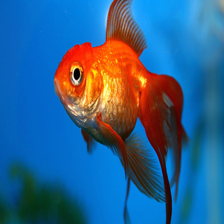

In [ ]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
gold_fish

In [ ]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [ ]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [ ]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [ ]:
with open('ImageNetLabels.txt','r') as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [ ]:
dataset_url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
data_dir = tf.keras.utils.get_file('flower_photos',origin=dataset_url,cache_dir='.', untar=True)
data_dir

228827136/228813984 [==============================] - 1s 0us/step


'./datasets/flower_photos'

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [ ]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/sunflowers/10386525695_2c38fea555_n.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/184683023_737fec5b18.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/3865206264_5d81584bba.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/3912497888_e7a5905bc3_n.jpg'),
 PosixPath('datasets/flower_photos/sunflowers/2689228449_e0be72cf00_n.jpg')]

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

In [ ]:
roses = list(data_dir.glob('roses/*'))
len(roses)

641

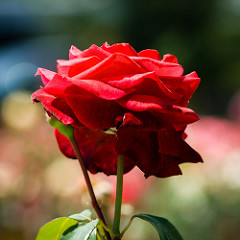

In [ ]:
Image.open(str(roses[-1]))

In [ ]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [ ]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [ ]:
img = cv2.imread(str(flowers_images_dict['roses'][1]))
img.shape

(246, 320, 3)

In [ ]:
X,y = [],[]

for flower_name, images in flowers_images_dict.items():
    for flower in images:
        img = cv2.imread(str(flower))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

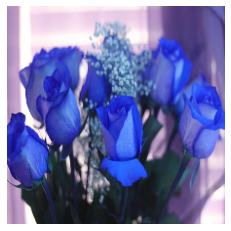

In [ ]:
plt.axis('off')
plt.imshow(X[0])

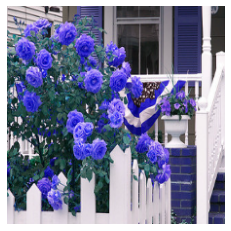

In [ ]:
plt.axis('off')
plt.imshow(X[1])

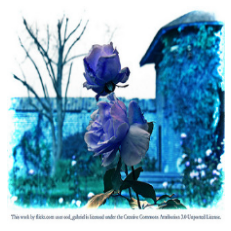

In [ ]:
plt.axis('off')
plt.imshow(X[2])

In [ ]:
np.array([X[0],X[1],X[2]]).shape

(3, 224, 224, 3)

In [ ]:
predicted = classifier.predict(X[:5])
predicted = np.argmax(predicted,axis=1)
predicted

array([795, 795, 795, 722, 550])

In [ ]:
image_labels[550]

'envelope'

In [ ]:
feature_extractor_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model,input_shape=(224,224,3),trainable=False
)

In [ ]:
num_of_flowers = 5

model = tf.keras.Sequential([
                             pretrained_model_without_top_layer,
                             tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

model.fit(X_train_scaled,y_train,epochs=5)

Epoch 1/5
86/86 [==============================] - 7s 40ms/step - loss: 0.8624 - acc: 0.6820
Epoch 2/5
86/86 [==============================] - 3s 41ms/step - loss: 0.4260 - acc: 0.8521
Epoch 3/5
86/86 [==============================] - 3s 41ms/step - loss: 0.3389 - acc: 0.8841
Epoch 4/5
86/86 [==============================] - 4s 41ms/step - loss: 0.2805 - acc: 0.9117
Epoch 5/5
86/86 [==============================] - 3s 41ms/step - loss: 0.2430 - acc: 0.9251


In [ ]:
# Better than CNN from scratch